# 序列模型
:label:`sec_sequence`

想象一下有人正在看网飞（Netflix，一个国外的视频网站）上的电影。
一名忠实的用户会对每一部电影都给出评价，
毕竟一部好电影需要更多的支持和认可。
然而事实证明，事情并不那么简单。
随着时间的推移，人们对电影的看法会发生很大的变化。
事实上，心理学家甚至对这些现象起了名字：

* *锚定*（anchoring）效应：基于其他人的意见做出评价。
  例如，奥斯卡颁奖后，受到关注的电影的评分会上升，尽管它还是原来那部电影。
  这种影响将持续几个月，直到人们忘记了这部电影曾经获得的奖项。
  结果表明（ :cite:`Wu.Ahmed.Beutel.ea.2017`），这种效应会使评分提高半个百分点以上。
* *享乐适应*（hedonic adaption）：人们迅速接受并且适应一种更好或者更坏的情况
  作为新的常态。
  例如，在看了很多好电影之后，人们会强烈期望下部电影会更好。
  因此，在许多精彩的电影被看过之后，即使是一部普通的也可能被认为是糟糕的。
* *季节性*（seasonality）：少有观众喜欢在八月看圣诞老人的电影。
* 有时，电影会由于导演或演员在制作中的不当行为变得不受欢迎。
* 有些电影因为其极度糟糕只能成为小众电影。*Plan9from Outer Space*和*Troll2*就因为这个原因而臭名昭著的。

简而言之，电影评分决不是固定不变的。
因此，使用时间动力学可以得到更准确的电影推荐 :cite:`Koren.2009`。
当然，序列数据不仅仅是关于电影评分的。
下面给出了更多的场景。

* 在使用程序时，许多用户都有很强的特定习惯。
  例如，在学生放学后社交媒体应用更受欢迎。在市场开放时股市交易软件更常用。
* 预测明天的股价要比过去的股价更困难，尽管两者都只是估计一个数字。
  毕竟，先见之明比事后诸葛亮难得多。
  在统计学中，前者（对超出已知观测范围进行预测）称为*外推法*（extrapolation），
  而后者（在现有观测值之间进行估计）称为*内插法*（interpolation）。
* 在本质上，音乐、语音、文本和视频都是连续的。
  如果它们的序列被我们重排，那么就会失去原有的意义。
  比如，一个文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
* 地震具有很强的相关性，即大地震发生后，很可能会有几次小余震，
  这些余震的强度比非大地震后的余震要大得多。
  事实上，地震是时空相关的，即余震通常发生在很短的时间跨度和很近的距离内。
* 人类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。


## 训练

在了解了上述统计工具后，让我们在实践中尝试一下！
首先，我们生成一些数据：(**使用正弦函数和一些可加性噪声来生成序列数据，
时间步为$1, 2, \ldots, 1000$。**)


In [1]:
%matplotlib inline
import torch
from torch import nn


import sys
sys.path.append("..")
import d2lzh_pytorch.torch as d2l

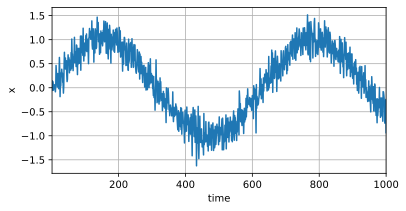

In [2]:

# 总共产生1000个点
T = 1000  
time = torch.arange(1, T + 1, dtype=torch.float32)

x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

# 画图
d2l.plot(time, 
         [x], 
         'time', 
         'x', 
         xlim=[1, 1000], 
         figsize=(6, 3)
        )

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


In [3]:
tau = 4

features = torch.zeros((T - tau, tau))

for i in range(tau):
    features[:, i] = x[i: T - tau + i]
    pass

labels = x[tau:].reshape((-1, 1))

In [16]:
features

tensor([[-0.0553,  0.1408,  0.0560,  0.1215],
        [ 0.1408,  0.0560,  0.1215, -0.0519],
        [ 0.0560,  0.1215, -0.0519,  0.0673],
        ...,
        [-0.2165, -0.3693, -0.7362, -0.5373],
        [-0.3693, -0.7362, -0.5373, -0.3661],
        [-0.7362, -0.5373, -0.3661, -0.2450]])

In [13]:
labels.shape

torch.Size([996, 1])

In [4]:
batch_size, n_train = 16, 600


# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                             batch_size, 
                             is_train=True
                           )

在这里，我们[**使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机**]，ReLU激活函数和平方损失。


In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

        
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net


# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备[**训练模型**]了。实现下面的训练代码的方式与前面几节（如 sec_linear_concise）中的循环训练基本相同。因此，我们不会深入探讨太多细节。


In [6]:
def train(net, train_iter, loss, epochs, lr):
    
    trainer = torch.optim.Adam(net.parameters(), lr)
    
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        pass
    pass

        
net = get_net()


In [7]:

# 训练
train(net, 
      train_iter, 
      loss, 
      5, 
      0.01
     )

epoch 1, loss: 0.057639
epoch 2, loss: 0.061449
epoch 3, loss: 0.060300
epoch 4, loss: 0.055370
epoch 5, loss: 0.059949


## 预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。
让我们看看这在实践中意味着什么。
首先是检查[**模型预测下一个时间步**]的能力，
也就是*单步预测*（one-step-ahead prediction）。


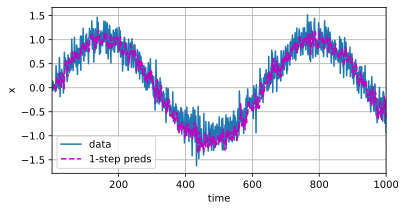

In [8]:
# 预测数据
onestep_preds = net(features)



d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 
         'time',
         'x', 
         legend=['data', '1-step preds'],
         xlim=[1, 1000],
         figsize=(6, 3)
        )

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。
让我们看看效果如何。


In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]


for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))
    pass
    

In [10]:
multistep_preds.size()

torch.Size([1000])

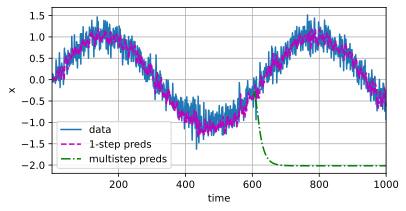

In [11]:
# 画图
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 
         'time',
         'x', 
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], 
         figsize=(6, 3)
        )

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。
我们将在本章及后续章节中讨论如何改进这一点。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，
让我们[**更仔细地看一下$k$步预测**]的困难。


In [11]:
max_steps = 64

In [12]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]


# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

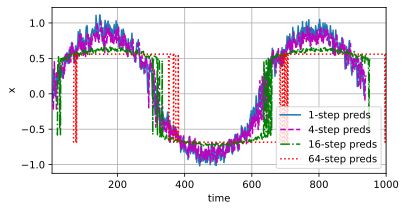

In [13]:
steps = (1, 4, 16, 64)


d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 
         'time', 
         'x',
         legend=[f'{i}-step preds' for i in steps], 
         xlim=[5, 1000],
         figsize=(6, 3)
        )

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。


## 小结

* 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
* 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
* 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
* 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。